### Notebook to plot number of cluster using MELD graph vs MELD MLP model

Evaluation done on test dataset

In [1]:
#imports
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from meld_graph.training import tp_fp_fn_tn, dice_coeff
from meld_classifier.meld_cohort import MeldSubject,MeldCohort
from meld_graph.icospheres import IcoSpheres
from meld_graph.graph_tools import GraphTools
import itertools
import pandas as pd
from meld_graph.evaluation import load_prediction
from meld_graph import experiment

Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to 
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350


### load per-vertex results

In [2]:
ref = '/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/iteration_21-09-15/ensemble_21-09-15/fold_all/results'
with h5py.File(os.path.join(ref, 'predictions_ensemble_iteration.hdf5'), "r") as f:
    subjects = list(f.keys())
subjects.remove('MELD_H4_3T_FCD_0011') # because does not exist in graph model
cohort = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')
print(len(subjects))

df_old=pd.DataFrame()
subjects_dictionary={}
values={}
for si,subj in enumerate(subjects):
    if si%100==0:
        print(si)
    values['ID']=subj
    s = MeldSubject(subj,cohort=cohort)
    values['group']= True if s.group=='patient' else False
    labels_hemis = {}
    dists={}
    labels = np.zeros(len(cohort.cortex_label)*2)
    for hemi in ['lh','rh']:
        dists[hemi], labels_hemis[hemi] = s.load_feature_lesion_data(
                    features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                )
        if np.sum(dists[hemi])==0:
            dists[hemi] +=200
    labels = np.hstack([labels_hemis['lh'][cohort.cortex_mask],labels_hemis['rh'][cohort.cortex_mask]])
    borderzones = np.vstack([dists['lh'][cohort.cortex_mask,:],dists['rh'][cohort.cortex_mask,:]]).ravel()<20
    
    #load pred from old classifier
    pred_file_old = os.path.join(ref, 'predictions_ensemble_iteration.hdf5')
    result_hemis_old = load_prediction(subj,pred_file_old, dset='prediction')
    result_old = np.hstack([result_hemis_old['lh'],result_hemis_old['rh']])
    values['model']='per vertex'
    
    #add detection with borderzone
    if labels.sum()>0:
        values['detected'] = np.logical_and(result_old, borderzones).any()
        values['number TP clusters'] = len(set(result_old[borderzones.astype('bool')]))-1
    else:
        values['number TP clusters'] = 0
    # add number of FP clusters : total clusters - TP clusters
    values['number FP clusters']=len(set(result_hemis_old['lh']))+len(set(result_hemis_old['rh']))-2-values['number TP clusters']
    df_old=pd.concat([df_old,pd.DataFrame([values])])
df_old = df_old.reset_index()
df_old.head()

453
0
100
200
300
400


,index,ID,group,model,detected,number TP clusters,number FP clusters
0,0,MELD2_H7_3T_FCD_001,True,per vertex,False,0,3
1,0,MELD2_H7_3T_FCD_004,True,per vertex,False,0,1
2,0,MELD2_H7_3T_FCD_005,True,per vertex,False,0,0
3,0,MELD2_H7_3T_FCD_009,True,per vertex,True,2,2
4,0,MELD_H10_3T_C_0005,False,per vertex,True,0,0


In [3]:
sensitivity = np.mean(df_old['detected'][df_old['group']])
specificity = (df_old['number FP clusters'][df_old['group']==0]>0).mean()
total_detected = np.sum(df_old['number TP clusters'][df_old['group']])
total_predicted = np.sum(df_old['number FP clusters'][df_old['group']])
ppv = total_detected / (total_predicted + total_detected)
print(np.round(sensitivity,2),np.round(1-specificity,2),np.round(ppv,2))

0.67 0.54 0.39


### load results for meld graph model

In [5]:

experiment_dir = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350'
model = '23-10-30_FOPF_dcop'

df_model = pd.read_csv(os.path.join(experiment_dir,model,
                                          's_0','fold_all','results_best_model','test_results.csv'))

df_model['model'] = ['graph' for x in df_model.iterrows()]
df_model = df_model[['ID','group','detected','number FP clusters','number TP clusters', 'model']]
df_model.head()

,ID,group,detected,number FP clusters,number TP clusters,model
0,MELD_H2_15T_FCD_0001,True,False,0,0,graph
1,MELD_H2_15T_FCD_0003,True,True,0,1,graph
2,MELD_H2_15T_FCD_0005,True,False,1,0,graph
3,MELD_H2_15T_FCD_0007,True,True,0,1,graph
4,MELD_H2_15T_FCD_0008,True,False,1,0,graph


In [9]:
sensitivity = np.mean(df_model['detected'][df_model['group']])
specificity = (df_model['number FP clusters'][df_model['group']==0]>0).mean()
total_detected = np.sum(df_model['number TP clusters'][df_model['group']])
total_predicted = np.sum(df_model['number FP clusters'][df_model['group']])
ppv = total_detected / (total_predicted + total_detected)
print(np.round(sensitivity,2),np.round(1-specificity,2),np.round(ppv,2))

0.68 0.7 0.66


In [10]:
## Concat results

df = pd.concat([df_old, df_model], ignore_index=True)
df.head()

,index,ID,group,model,detected,number TP clusters,number FP clusters
0,0.0,MELD2_H7_3T_FCD_001,True,per vertex,False,0,3
1,0.0,MELD2_H7_3T_FCD_004,True,per vertex,False,0,1
2,0.0,MELD2_H7_3T_FCD_005,True,per vertex,False,0,0
3,0.0,MELD2_H7_3T_FCD_009,True,per vertex,True,2,2
4,0.0,MELD_H10_3T_C_0005,False,per vertex,True,0,0


### plot number of clusters

/tmp/ipykernel_48094/1198584314.py:48: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  axs[i].scatter(x, y, marker='o')


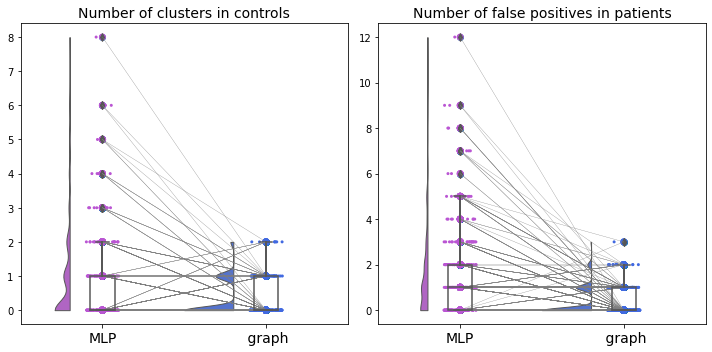

In [11]:
import ptitprince as pt
import matplotlib.gridspec as gridspec

def get_connection(df):
    connects=[]
    for subject in np.unique(df['ID']):
        subdf=df[df['ID']==subject]
        connects.append([subdf[subdf['model']=='per vertex'].index[0],
                        subdf[subdf['model']=='graph'].index[0]])
    return connects

def connectpoints(x,y,p1,p2,colors):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.scatter([x1,x2],[y1,y2], c=colors)
    plt.plot([x1,x2],[y1,y2], 'grey', linewidth=0.3)
    

fig = plt.figure(figsize=(10,5))
gs1 = gridspec.GridSpec(1, 2)
axs = []

ort='v'
pal={'per vertex':'mediumorchid', 'graph':'royalblue'}

for i,group in enumerate([False,True]):
    axs.append(fig.add_subplot(gs1[i]))
    subdf=df[df['group']==group]
    subdf.reset_index(drop=True, inplace=True)
    if group == True:
        y_var = 'number FP clusters'
        ax_label = 'Number of false positives in patients'
    else:
        y_var = 'number FP clusters'
        ax_label = 'Number of clusters in controls'
    axs[i]=pt.RainCloud(x='model', y=y_var, palette = pal, data=subdf, bw= .2, cut=0, 
                            scale="area", width_viol=.6, orient=ort, jitter = 0.1, dodge=False)
    # axs[i].set_title('group)
    axs[i].set_title(ax_label, fontsize='14')
    locs, labels = plt.xticks()  # Get the current locations and labels.
    axs[i].set_xticks(locs, labels=['MLP',' graph'], fontsize='14')
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    #plot connections
    connects=get_connection(subdf)
    x=subdf['model'].to_numpy()
    y=subdf['number FP clusters'].to_numpy()
    axs[i].scatter(x, y, marker='o')
    axs[i].set_xlim([-0.5,1.5])
    for connect in connects:
        connectpoints(x,y,connect[0],connect[1], colors = [pal['per vertex'],pal['graph']])
    plt.tight_layout()
    
